# Végétalisons Paris

Le but de ce projet est d'effectuer une analyse exploratoire à partir des données d'opendata.paris.fr portant sur les arbres de la ville de Paris dans le cadre du programme "Végétalisons la ville". 

L'objectif est d'optimiser les tournées d'entretien des arbres en réduisant le nombre de déplacements, ce qui permettra de maintenir davantage d'arbres.

# Import des librairies

In [1]:
# Importation des librairies

import pandas as pd
import numpy as np

# Visualisation
import folium
import seaborn as sns

# Exploration des données

In [2]:
# Chargement des données dans une dataframe
df = pd.read_csv("data/p2-arbres-fr.csv", sep=';')

In [3]:
df.shape

(200137, 18)

In [4]:
df.columns

Index(['id', 'type_emplacement', 'domanialite', 'arrondissement',
       'complement_addresse', 'numero', 'lieu', 'id_emplacement',
       'libelle_francais', 'genre', 'espece', 'variete', 'circonference_cm',
       'hauteur_m', 'stade_developpement', 'remarquable', 'geo_point_2d_a',
       'geo_point_2d_b'],
      dtype='object')

### Suppression des colonnes inutiles 

In [5]:
# On regarde la quantité de valeurs NaN présentes dans notre jeu de données

pd.DataFrame(df.isna().mean().round(4) * 100,
             columns=['Données manquantes en %'
                      ]).sort_values(by='Données manquantes en %',
                                     ascending=False)

,Données manquantes en %
numero,100.00
complement_addresse,84.56
variete,81.62
stade_developpement,33.58
remarquable,31.53
espece,0.88
libelle_francais,0.75
genre,0.01
geo_point_2d_a,0.00
hauteur_m,0.00


Regardons de plus près les colonnes contenant des valeurs manquantes dans l'ordre décroissant.

- **"numero"** à 100% : corresponds certainement au numéro d'adresse de "lieu". La colonne "lieu" indiquant déjà l'adresse, il ne semble pas nécessaire de corriger ou conserver cette colonne.
- **"complement_adresse"** à 84,6% : les adresses ne contiennent pas forcément des compléments.
- **"variete"** à 81,6% : afin de remplir les données manquantes, nous pouvons analyser les colonnes "libelle_francais", "genre" et "espece" qui contiennent des variétés et analyser la corrélation, où utiliser une colonne du même genre ayant le moins de valeurs null.
- **"stade_developpement"** à 33,6% : corresponds à l'âge de l'arbre. Il nous est possible d'estimer les valeurs NULL en comparant "libelle_francais", "genre", "espece" ou "variete" avec "circonference_cm" et "hauteur_m".

Voici les valeurs :
- A : Adulte
- J : Jeune
- JA : Jeune Adulte
- M : Mature


- **"remarquable"** à 31,5% : un arbre remarquable relève d'un patrimoine par sa rareté, ses dimensions, sa position, son âge ou encore sa force symbolique. Certaines valeurs peuvent donc être estimées par des critères concrets comme l'espèce, la hauteur, la dimension, le stade de développement ou la position, mais aussi par des critères abstraits comme le symbole. Comme il est difficile d'estimer une valeur basée sur une notion abstraite, nous essaierons de trouver une solution plus tard.
- **"espece"** à 0,9%, **"libelle_francais"** à 0,7% et **"genre"** à 0,01% : le nombre de valeurs manquantes est très faible, nous pouvons supprimer les valeurs NULL.
- **"id"** à 0% : les ID sont par définition non nuls et uniques.

Nous avons maintenant une bonne approche sur le contenu du jeu de données.

Avant de traiter les données manquantes, il nous faudra d'abord traiter les d’aberrations (les erreurs). Nous verrons cela dans les prochaines étapes.

Vérifions si le type de donnée des colonnes correspond bien aux valeurs.

## Type de données

In [6]:
# Échantillon

df.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   200137 non-null  int64  
 1   type_emplacement     200137 non-null  object 
 2   domanialite          200136 non-null  object 
 3   arrondissement       200137 non-null  object 
 4   complement_addresse  30902 non-null   object 
 5   numero               0 non-null       float64
 6   lieu                 200137 non-null  object 
 7   id_emplacement       200137 non-null  object 
 8   libelle_francais     198640 non-null  object 
 9   genre                200121 non-null  object 
 10  espece               198385 non-null  object 
 11  variete              36777 non-null   object 
 12  circonference_cm     200137 non-null  int64  
 13  hauteur_m            200137 non-null  int64  
 14  stade_developpement  132932 non-null  object 
 15  remarquable      

Avant de commencer à analyser la correspondance des types de données, voici un rappel sur les types :
- object = Texte ou valeurs numériques et non numériques mixtes
- int64 = Nombres entiers
- float64 = Nombres à virgule flottante
- bool = Valeurs vraies/fausses

Que pouvons-nous remarquer ? :
- **"id"** int64 : le type correspond. L'ID débute à partir de 99874 et s'incrémente de 1 dans l'ordre croissant.
- **"type_emplacement"** object: le type correspond. Les valeurs semblent toutes être identique "Arbre". Il faudra vérifier les valeurs uniques de cette colonne. Si les données s’avèrent identiques, nous pourrons remettre en question son utilité.
- **"domanialite"** object : le type correspond. Nous pourrons explorer les valeurs uniques après.
- **"arrondissement"** object : le type correspond.
- **"numero"** float64 : le type correspond, mais ne contient que des valeurs Null.
- **"lieu"** object : le type correspond.
- **"id_emplacement"** object : le type correspond, néanmoins cette colonne reste étrange. Elles sont généralement de type int64 (ex. : 9) et quelquefois de type object (ex. : 000G0037) comme on peut le voir dans le df.head().
- **"complement_addresse"**, **"libelle_francais"**, **"genre"**, **"espece"**, **"variete"** et **"stade_developpement"** object : le type correspond.
- **"circonference_cm"** et **"hauteur_m"** int64 : le type correspond.
- **"remarquable"** float64 : le type ne correspond pas. Il faut le corriger en type bool.
- **"geo_point_2d_a"**, **"geo_point_2d_b"** float64 : le type correspond.

Cette étape nous a appris que même si certains types de données sont exactes nous pouvons tout de même l'optimiser, comme la colonne **"remarquable"** où il est préférable de la convertir en bool.

In [8]:
# Regardons la colonne 'type_emplacement' pour s'assurer qu'il n'y est qu'une seul valeur unique 
# avant de l'écarter de la dataframe.
df["type_emplacement"].unique()

array(['Arbre'], dtype=object)

In [9]:
# La colonne 'numero' n'a que des valeurs null.
# La colonne 'type_emplacement' n'a qu'une valeur unique, 'Arbre'.
# Nous allons donc les écartés de notre dataframe.

df.pop("numero")
df.pop("type_emplacement")

0         Arbre
1         Arbre
2         Arbre
3         Arbre
4         Arbre
          ...  
200132    Arbre
200133    Arbre
200134    Arbre
200135    Arbre
200136    Arbre
Name: type_emplacement, Length: 200137, dtype: object

# Nettoyage

## Doublons

Compte tenu de la consigne du projet qui suggère de ne pas trop s'attarder sur l’exploration, nous nous limiterons à "id" et aux coordonnées géographiques pour la détection des doublons, techniquement 2 arbres ne peuvent pas être exactement au même endroit.

In [10]:
df[df.duplicated(['id'])]

,id,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b


In [11]:
# Recherche de doublons dans les coordonnées géographiques
df[df.duplicated(['geo_point_2d_a', 'geo_point_2d_b'],
                 keep=False)].sort_values(["geo_point_2d_a", "geo_point_2d_b"])

,id,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
185479,2006187,Alignement,BOIS DE VINCENNES,NaN,ROUTE DAUPHINE,402029,Tilleul,Tilia,platyphyllos,NaN,0,0,NaN,0.0,48.829912,2.439665
185480,2006188,Alignement,BOIS DE VINCENNES,NaN,ROUTE DAUPHINE,402030,Tilleul,Tilia,platyphyllos,NaN,0,0,NaN,0.0,48.829912,2.439665
189133,2011522,Jardin,BOIS DE VINCENNES,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,190042,Peuplier,Populus,nigra,NaN,0,0,NaN,0.0,48.836416,2.446277
189134,2011523,Jardin,BOIS DE VINCENNES,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,190042,Peuplier,Populus,nigra,Italica',100,22,A,0.0,48.836416,2.446277
188329,2010634,Jardin,BOIS DE VINCENNES,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,210034,Hêtre,Fagus,sylvatica,Rotundifolia',75,8,JA,0.0,48.836862,2.446518
193577,2016369,Jardin,BOIS DE VINCENNES,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,210035,Pommier à fleurs,Malus,trilobata,NaN,0,0,NaN,0.0,48.836862,2.446518
10099,112286,Jardin,PARIS 12E ARRDT,NaN,JARDIN PARTAGE BEL-AIR,5,Ailante,Ailanthus,altissima,NaN,0,0,NaN,NaN,48.838318,2.406610
10100,112287,Jardin,PARIS 12E ARRDT,NaN,JARDIN PARTAGE BEL-AIR,6,Ailante,Ailanthus,altissima,NaN,0,0,NaN,NaN,48.838318,2.406610
188427,2010732,Jardin,BOIS DE VINCENNES,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,20069,Cèdre,Cedrus,libani subsp. atlantica,NaN,110,18,A,0.0,48.838539,2.439350
193587,2016379,Jardin,BOIS DE VINCENNES,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,20129,Cèdre,Cedrus,libani subsp. atlantica,NaN,0,0,NaN,0.0,48.838539,2.439350


Voici ce que nous pouvons constater sur l'analyse des doublons :
- Des arbres sont identiques, mais ont un "id_emplacement" qui diffère, très souvent de +1.
- Certains arbres identiques avec le même "id_emplacement" ont plus de données NULL que dans l'autre.
- Certains arbres ont une espèce différente au même endroit. Peut-être que des arbres ont été remplacés depuis et que le doublon correspond à un ancien arbre qui n'existe plus. Si c'est le cas, comment reconnaître le plus récent sans la date ?

Nous pouvons en conclure que plusieurs moyens différants doivent être employés pour nettoyer les doublons. Cependant vu le faible nombre et le temps disponible, nous pouvons les supprimer.

In [12]:
df = df.drop_duplicates(subset=['geo_point_2d_b'])
df = df.drop_duplicates(subset=['geo_point_2d_a'])

In [13]:
# Vérification des suppressions de doublons

df[df.duplicated(['geo_point_2d_a', 'geo_point_2d_b'],
                 keep=False)].sort_values(["geo_point_2d_a", "geo_point_2d_b"])

,id,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b


## Aberration

Dans cette partie, nous allons analyser les données à la recherche d'incohérences, et allons les traiter avec la méthode des interquartile.

>L'interquartile nous donne une idée de la dispersion des données. Si l'interquartile est petit, cela signifie que les données sont relativement groupées autour de la médiane. Si l'interquartile est grand, cela signifie que les données sont plus dispersées.
En somme, l'interquartile est une mesure statistique simple mais utile pour avoir une idée de la dispersion des données dans un ensemble de données.

In [14]:
# Suppression des valeurs de la colonne circonference_cm et hauteur_m aberrantes que nous avons remarqués
# dans le tableau df.describe(), un arbre en France ne peux pas avoir une circonférence supérieure à 15 mètres, et une hauteur
# de 100 mètres.

df.drop(df.loc[df['circonference_cm'] > 15000].index, inplace=True)
df.drop(df.loc[df['hauteur_m'] > 100].index, inplace=True)

In [15]:
df_haut = df[['hauteur_m']]

In [16]:
print(df_haut.min(), df_haut.max())

hauteur_m    0
dtype: int64 hauteur_m    100
dtype: int64


<Axes: xlabel='hauteur_m'>

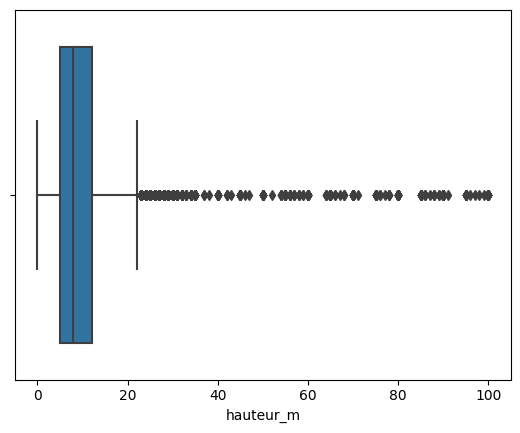

In [17]:
sns.boxplot(data=df,x=df['hauteur_m'])

In [18]:
Q1 = df['hauteur_m'].quantile(0.25)
Q3 = df['hauteur_m'].quantile(0.75)
IQR = Q3 - Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5 * IQR
Upper_Whisker = Q3 + 1.5 * IQR
print(Lower_Whisker, Upper_Whisker)

5.0
12.0
7.0
-5.5 22.5


In [19]:
df = df[df['hauteur_m'] < Upper_Whisker]

<Axes: xlabel='hauteur_m'>

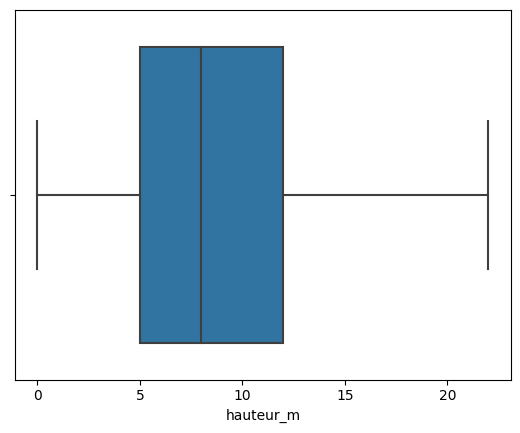

In [20]:
sns.boxplot(data=df, x=df['hauteur_m'])

In [21]:
df_haut = df[['hauteur_m']]
print(df_haut.min(), df_haut.max())

hauteur_m    0
dtype: int64 hauteur_m    22
dtype: int64


On peut remarquer que les valeurs aberrantes on bien était supprimées, faisons la même chose avec la colonne circonference_cm à présent (les valeurs 0 seront traitées dans la section des valeurs null manquantes).

<Axes: xlabel='circonference_cm'>

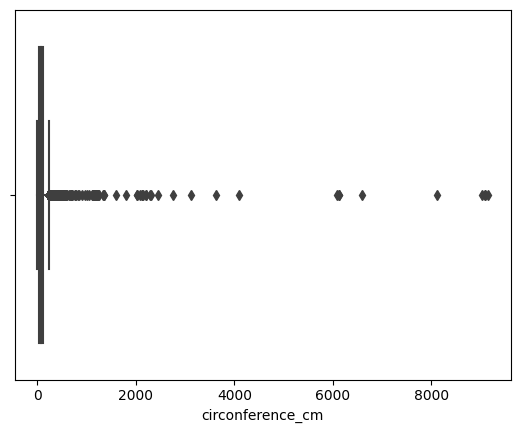

In [22]:
sns.boxplot(data=df, x=df['circonference_cm'])

In [23]:
Q1 = df['circonference_cm'].quantile(0.25)
Q3 = df['circonference_cm'].quantile(0.75)
IQR = Q3 - Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5 * IQR
Upper_Whisker = Q3 + 1.5 * IQR
print(Lower_Whisker, Upper_Whisker)

30.0
110.0
80.0
-90.0 230.0


In [24]:
df = df[df['circonference_cm'] < Upper_Whisker]

<Axes: xlabel='circonference_cm'>

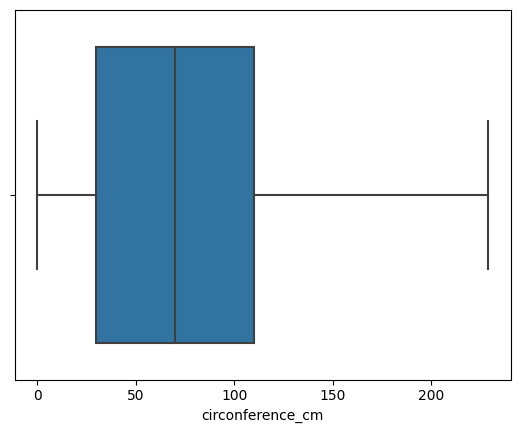

In [25]:
sns.boxplot(data=df,x=df['circonference_cm'])

In [26]:
df_cir = df[['circonference_cm']]
print(df_cir.min(), df_cir.max())

circonference_cm    0
dtype: int64 circonference_cm    229
dtype: int64


Nous avons maintenant terminé de traiter les valeurs aberrantes.

## Valeurs NULL et manquantes

Dans cette partie, nous allons les traiter les valeurs null et manquantes, en les remplaçant par une moyenne.

Commençons par supprimer les lignes des colonnes ayant un très faible taux de valeurs null.

Rappelle de ses valeurs :

**"espece"** à 0,9%, **"libelle_francais"** à 0,7% et **"genre"** à 0,01%.

In [27]:
print(df['espece'].isna().sum())
print(df['libelle_francais'].isna().sum())
print(df['genre'].isna().sum())

# Suppression des valeurs NaN
df = df.dropna(subset=['espece'])
df = df.dropna(subset=['libelle_francais'])
df = df.dropna(subset=['genre'])

print(df['espece'].isna().sum())
print(df['libelle_francais'].isna().sum())
print(df['genre'].isna().sum())

1749
1475
16
0
0
0


Maintenant, occupons-nous des valeurs Null des colonnes **circonference_cm** et **hauteur_m**.

In [28]:
df.describe()

,id,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
count,1.899370e+05,189937.000000,189937.000000,128984.000000,189937.000000,189937.000000
mean,3.824351e+05,74.233609,7.905295,0.000558,48.854623,2.347800
std,5.387419e+05,54.212193,5.678485,0.023620,0.030197,0.051383
min,9.987400e+04,0.000000,0.000000,0.000000,48.742290,2.210241
25%,1.560690e+05,30.000000,4.000000,0.000000,48.835153,2.306954
50%,2.208720e+05,70.000000,8.000000,0.000000,48.854144,2.350512
75%,2.736850e+05,110.000000,12.000000,0.000000,48.876461,2.386912
max,2.024745e+06,229.000000,22.000000,1.000000,48.911485,2.469759


Nous remplaçons les valeurs null (0) des colonnes circonference_cm et hauteurs-m par des valeurs manquantes (NaN), puis nous pouvons ensuite remplacer ces valeurs NaN par les valeurs moyennes de la colonne et ayant le même libellé.

In [29]:
df['circonference_cm'] = df['circonference_cm'].replace(0, np.nan)
df['circonference_cm'] = df['circonference_cm'].fillna(df.groupby('libelle_francais')['circonference_cm'].transform('mean'))

df['hauteur_m'] = df['hauteur_m'].replace(0, np.nan)
df['hauteur_m'] = df['hauteur_m'].fillna(df.groupby('libelle_francais')['hauteur_m'].transform('mean'))

In [30]:
df_cir_haut = df[['hauteur_m', 'circonference_cm']]

In [31]:
print(df_cir_haut.min(), df_cir_haut.max())

hauteur_m           1.0
circonference_cm    1.0
dtype: float64 hauteur_m            22.0
circonference_cm    229.0
dtype: float64


On constate qu'il n'y a plus de valeur NULL dans les colonnes circonference_cm et hauteur_m, nous allons donc pouvoir passer au traitement des aberrations.

Maintenant, occupons-nous des valeurs NaN dans la colonnes stade_developpement.

In [32]:
# Nous listons les espèces d'arbres et les différents stades de développement

list_espece = df['libelle_francais'].unique().tolist()
list_stade_developpement = df['stade_developpement'].unique().tolist()

# Ensuite, nous plaçons dans des variables, la quantité de chaque stade de développement pour chaque arbre.
# Nous plaçons ensuite ces variables dans un dictionnaire ayant pour clé le stade de développement en question.
# Nous définissons ensuite la variable max_key par la valeur la plus élevé des stades de développement pour chaque arbre.
# Et enfin, nous plaçons tout cela dans un dictionnaire, où la clé est l'arbre et la valeur le stade de développement
# le plus présent dans cette espèce.

dict_arbre_max_stade = {}

for arbre in list_espece:
    quantite_arbre_J = df.loc[(df['libelle_francais'] == arbre) & (df['stade_developpement'] == "J")].count()
    quantite_par_arbre_JA = df.loc[(df['libelle_francais'] == arbre) & (df['stade_developpement'] == "JA")].count()
    quantite_par_arbre_A = df.loc[(df['libelle_francais'] == arbre) & (df['stade_developpement'] == "A")].count()
    quantite_par_arbre_M = df.loc[(df['libelle_francais'] == arbre) & (df['stade_developpement'] == "M")].count()
    
    quantite_stade_dev = {'J': quantite_arbre_J.loc['id'], 'JA': quantite_par_arbre_JA.loc['id'], 
                         'A': quantite_par_arbre_A.loc['id'], 'M': quantite_par_arbre_M.loc['id']}
    
    max_key = max(quantite_stade_dev, key=quantite_stade_dev.get)
    
    dict_arbre_max_stade[arbre] = max_key

In [33]:
dict_arbre_max_stade

{'Marronnier': 'A',
 'If': 'A',
 'Erable': 'A',
 'Arbre à miel': 'J',
 'Sophora': 'A',
 'Prunus n. sp.': 'J',
 'Hêtre': 'A',
 'Micocoulier': 'A',
 'Tilleul': 'A',
 'Chêne': 'J',
 'Savonnier': 'JA',
 'Copalme': 'J',
 'Noyer': 'JA',
 'Arbre à caramel': 'J',
 'Troene': 'J',
 'Tulipier': 'A',
 'Pin': 'A',
 'Sapin': 'A',
 'Cerisier à fleurs': 'A',
 'Charme-Houblon': 'J',
 'Cèdre': 'A',
 'Paulownia': 'A',
 'Thuya': 'A',
 'Pommier à fleurs': 'J',
 'Poirier': 'J',
 'Pommier': 'J',
 'Bouleau': 'JA',
 'Orme': 'A',
 'Arbre de Judée': 'J',
 'Robinier': 'A',
 'Frêne': 'A',
 'Aubépine': 'A',
 'Fevier': 'J',
 'Prunier à fleurs': 'A',
 'Arbre aux quarante écus': 'JA',
 'Néflier commun': 'J',
 'Platane': 'A',
 'Saule': 'A',
 'Magnolia': 'A',
 'Prunier à fruits': 'J',
 'Poirier à fleurs': 'J',
 'Faux-cyprès': 'A',
 'Aubepine': 'A',
 'Plaqueminier': 'A',
 'Mûrier': 'A',
 'Pêcher': 'J',
 'Pterocarya': 'A',
 'Merisier': 'J',
 'Noisetier de Byzance': 'JA',
 'Alisier': 'JA',
 'Cognassier': 'J',
 'Parrotie de

Nous avons maintenant un dictionnaire avec pour clés les arbres, et pour valeurs leur stade de développement les plus présents.

Changeons maintenant les valeurs NaN par 0 pour ensuite les remplacer, à l'aide du dictionnaire dict_arbre_max_stade, par le stade de développement le plus présent de l'arbre.

In [34]:
df['stade_developpement'] = df['stade_developpement'].replace(np.nan, 0)

In [35]:
for arbre, value in dict_arbre_max_stade.items():
    df.loc[(df.libelle_francais == arbre),'stade_developpement'] = value

In [36]:
df.loc[(df['stade_developpement'] == 0)]

,id,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b


In [37]:
df['stade_developpement'].isna().sum()

0

Occupons-nous de la colonne 'remarquable', composé de float au lieu de booléens. Les valeurs NaN de cette colonne sont difficilement remplaçables, sachant qu'un arbre est soit remarquable, soit non. Nous allons donc remplacer "1.0" par True et "0.0" par False, nous allons aussi remplacer les valeurs NaN par False.

In [38]:
df['remarquable'].unique()

array([ 0., nan,  1.])

In [39]:
df['remarquable'] = df['remarquable'].replace(np.nan, 0)
df['remarquable'] = df['remarquable'].replace([0., 0], False)
df['remarquable'] = df['remarquable'].replace([1.], True)

In [40]:
df['remarquable'].unique()

array([False,  True])

Nous avons maintenant une colonne avec des valeurs booléennes propres.

# Visualisation

## Population d'arbre par arrondissement

Nous allons explorer le nombre d'arbres sur Paris, puisqu'une ligne correspond à un arbre, nous pouvons alors déterminer cette quantité simplement.

Le seul souci, est que cette quantité n'est pas fiable à 100 % au vu du nettoyage des données où certains arbres ont probablement étés supprimés du jeu de données initial.

In [41]:
# Quantité d'arbres

len(df.index)

189937

Nous allons maintenant faire un classement de la population d'arbre par arrondissement. Avant cela, listons les différents arrondissements.

In [42]:
arrondissement_list = df['arrondissement'].unique().tolist()
arrondissement_list

['PARIS 7E ARRDT',
 'PARIS 17E ARRDT',
 'PARIS 16E ARRDT',
 'PARIS 4E ARRDT',
 'PARIS 13E ARRDT',
 'PARIS 12E ARRDT',
 'PARIS 19E ARRDT',
 'PARIS 14E ARRDT',
 'PARIS 15E ARRDT',
 'PARIS 3E ARRDT',
 'PARIS 20E ARRDT',
 'PARIS 18E ARRDT',
 'PARIS 6E ARRDT',
 'PARIS 11E ARRDT',
 'PARIS 1ER ARRDT',
 'PARIS 2E ARRDT',
 'PARIS 5E ARRDT',
 'VAL-DE-MARNE',
 'SEINE-SAINT-DENIS',
 'HAUTS-DE-SEINE',
 'PARIS 9E ARRDT',
 'PARIS 10E ARRDT',
 'PARIS 8E ARRDT',
 'BOIS DE BOULOGNE',
 'BOIS DE VINCENNES']

Attribuons maintenant la quantité d'arbres par arrondissement dans un dictionnaire.

In [43]:
population_arbre = {}

for ar in arrondissement_list :
    population = df.loc[df.arrondissement == ar, 'arrondissement'].count()
    population_arbre[ar] = population
    
print(population_arbre)

{'PARIS 7E ARRDT': 8134, 'PARIS 17E ARRDT': 10438, 'PARIS 16E ARRDT': 15545, 'PARIS 4E ARRDT': 2592, 'PARIS 13E ARRDT': 15970, 'PARIS 12E ARRDT': 12023, 'PARIS 19E ARRDT': 12773, 'PARIS 14E ARRDT': 10781, 'PARIS 15E ARRDT': 16703, 'PARIS 3E ARRDT': 1170, 'PARIS 20E ARRDT': 14644, 'PARIS 18E ARRDT': 9618, 'PARIS 6E ARRDT': 1666, 'PARIS 11E ARRDT': 5503, 'PARIS 1ER ARRDT': 1337, 'PARIS 2E ARRDT': 528, 'PARIS 5E ARRDT': 2189, 'VAL-DE-MARNE': 6532, 'SEINE-SAINT-DENIS': 11117, 'HAUTS-DE-SEINE': 5281, 'PARIS 9E ARRDT': 1143, 'PARIS 10E ARRDT': 2818, 'PARIS 8E ARRDT': 6816, 'BOIS DE BOULOGNE': 3876, 'BOIS DE VINCENNES': 10740}


Nous allons ensuite ranger les valeurs dans l'ordre décroissant.

In [44]:
population_arbre = {k: v for k, v in sorted(population_arbre.items(), key=lambda item: item[1], reverse=True)}
population_arbre

{'PARIS 15E ARRDT': 16703,
 'PARIS 13E ARRDT': 15970,
 'PARIS 16E ARRDT': 15545,
 'PARIS 20E ARRDT': 14644,
 'PARIS 19E ARRDT': 12773,
 'PARIS 12E ARRDT': 12023,
 'SEINE-SAINT-DENIS': 11117,
 'PARIS 14E ARRDT': 10781,
 'BOIS DE VINCENNES': 10740,
 'PARIS 17E ARRDT': 10438,
 'PARIS 18E ARRDT': 9618,
 'PARIS 7E ARRDT': 8134,
 'PARIS 8E ARRDT': 6816,
 'VAL-DE-MARNE': 6532,
 'PARIS 11E ARRDT': 5503,
 'HAUTS-DE-SEINE': 5281,
 'BOIS DE BOULOGNE': 3876,
 'PARIS 10E ARRDT': 2818,
 'PARIS 4E ARRDT': 2592,
 'PARIS 5E ARRDT': 2189,
 'PARIS 6E ARRDT': 1666,
 'PARIS 1ER ARRDT': 1337,
 'PARIS 3E ARRDT': 1170,
 'PARIS 9E ARRDT': 1143,
 'PARIS 2E ARRDT': 528}

Visualisons tout ça avec un graphique.

<Axes: >

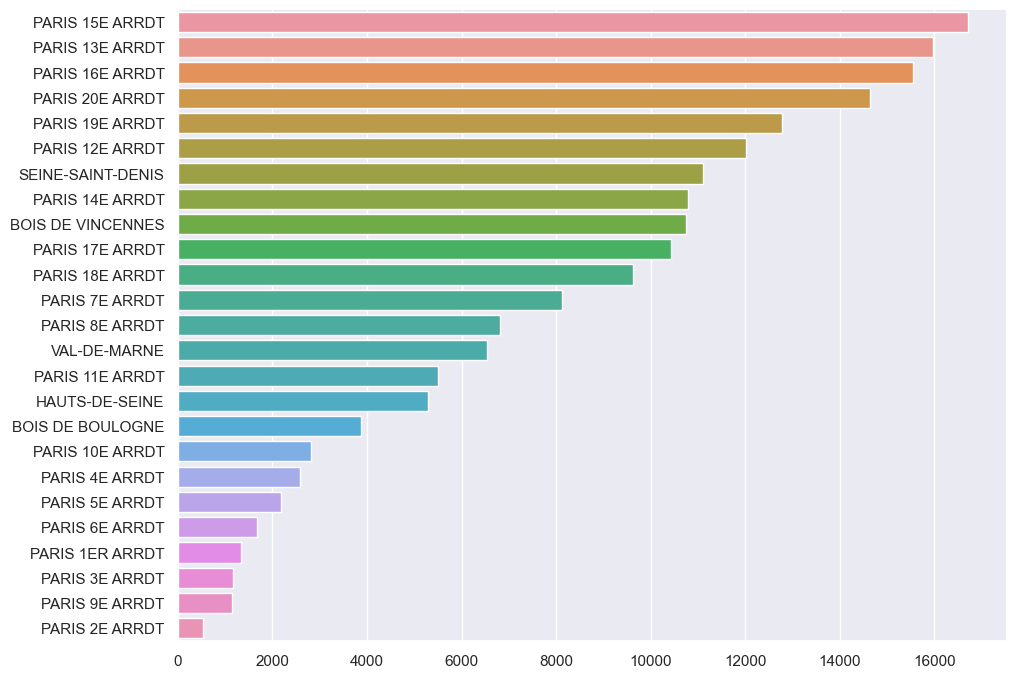

In [45]:
sns.set(rc={'figure.figsize': (10.7, 8.2)})
keys = list(population_arbre.keys())
vals = [float(population_arbre[k]) for k in keys]
sns.barplot(x=vals, y=keys)

In [46]:
quantite_arbre_ar = pd.DataFrame.from_dict(population_arbre, orient='index', columns=["quantite"])

quantite_arbre_ar['percent'] = (quantite_arbre_ar['quantite'] /
                                quantite_arbre_ar['quantite'].sum()) * 100

print(quantite_arbre_ar)

                   quantite   percent
PARIS 15E ARRDT       16703  8.793969
PARIS 13E ARRDT       15970  8.408051
PARIS 16E ARRDT       15545  8.184293
PARIS 20E ARRDT       14644  7.709925
PARIS 19E ARRDT       12773  6.724861
PARIS 12E ARRDT       12023  6.329994
SEINE-SAINT-DENIS     11117  5.852993
PARIS 14E ARRDT       10781  5.676093
BOIS DE VINCENNES     10740  5.654506
PARIS 17E ARRDT       10438  5.495506
PARIS 18E ARRDT        9618  5.063784
PARIS 7E ARRDT         8134  4.282473
PARIS 8E ARRDT         6816  3.588558
VAL-DE-MARNE           6532  3.439035
PARIS 11E ARRDT        5503  2.897276
HAUTS-DE-SEINE         5281  2.780396
BOIS DE BOULOGNE       3876  2.040677
PARIS 10E ARRDT        2818  1.483650
PARIS 4E ARRDT         2592  1.364663
PARIS 5E ARRDT         2189  1.152487
PARIS 6E ARRDT         1666  0.877133
PARIS 1ER ARRDT        1337  0.703918
PARIS 3E ARRDT         1170  0.615994
PARIS 9E ARRDT         1143  0.601778
PARIS 2E ARRDT          528  0.277987


Nous pouvons donc constater que la population d'arbres est plus importante dans les 15e, 13e, 16e, 20e et 19e arrondissements de Paris.

## Par dimension d'arbre

Nous allons regarder la moyenne de la hauteur et de la circonférence des arbres par libellé.

In [47]:
# Nous créons une dataframe avec trois colonnes : 'libelle_francais', 'hauteur_m', 'circonference_cm'.
# Les colonnes hauteur et circonférence ont pour valeur la moyenne du libelle de l'arbre.

df_dimension_mean = df.groupby('libelle_francais', as_index=False)[['hauteur_m', 'circonference_cm']].mean()

In [48]:
# Ensuite, nous imprimons les 5 premières lignes de la dataframe, une fois avec la hauteur en ordre décroissant,
# et une autre avec la circonférence.

print(df_dimension_mean.sort_values('hauteur_m', ascending=False).head(5), '\n\n')
print(df_dimension_mean.sort_values('circonference_cm', ascending=False).head(5))

    libelle_francais  hauteur_m  circonference_cm
84              Hiba  14.000000         75.000000
137         Peuplier  13.818695        113.879482
169          Sequoia  12.490196        108.884058
60             Cèdre  12.484404        121.858108
143          Platane  12.079161        100.427249 


         libelle_francais  hauteur_m  circonference_cm
177                 Sumac   4.666667        170.446809
141            Pistachier  12.000000        155.000000
178                Sureau   5.893617        124.019802
60                  Cèdre  12.484404        121.858108
16   Arbre à Gutta-Percha  10.500000        117.000000


In [49]:
# Nous imprimons ici les espèces d'arbres ayant la plus grande hauteur, et la plus grande circonférence.

print(df[['libelle_francais','hauteur_m']].sort_values('hauteur_m', 
      ascending=False).drop_duplicates(subset=['hauteur_m']).drop_duplicates(subset=['libelle_francais']).head(5), '\n\n')

print(df[['libelle_francais','circonference_cm']].sort_values('circonference_cm', 
      ascending=False).drop_duplicates(subset=['circonference_cm']).drop_duplicates(subset=['libelle_francais']).head(5))

       libelle_francais  hauteur_m
100298          Platane  22.000000
172273       Marronnier  19.000000
116205          Sophora  18.000000
50717             Frêne  14.000000
20458          Peuplier  13.818695 


       libelle_francais  circonference_cm
156363          Platane             229.0
21835           Tilleul             228.0
10638            Charme             226.0
182266       Marronnier             225.0
31423             Chêne             222.0


On constate qu'en moyenne les arbres les plus hauts de Paris sont :

- Platane
- Marronnier
- Sophora
- Frêne
- Peuplier

Qu'en moyenne, les arbres ayant la plus grande circonférence de Paris sont :

- Platane
- Tilleul
- Charme
- Marronnier
- Chêne

Puis on peut voir que l'espèce d'arbre ayant la plus grande hauteur est limitée à 22 mètres, c'est peut être lié à une limite de hauteur imposée par la ville pour des raisons de sécurité, en ce qui concerne la circonférence, c'est le Platane qui possède la plus grande hauteur et la plus grande des circonférences.

## Quelles espèces par domanialité

Nous allons explorer la quantité d'arbres par domanialité ainsi que la population principale des espèces qui les occupe.

In [50]:
domanialite_list = df['domanialite'].unique().tolist()
domanialite_list

['Jardin',
 'Alignement',
 'DJS',
 'DFPE',
 'CIMETIERE',
 'DASCO',
 'DAC',
 'PERIPHERIQUE',
 'DASES',
 nan]

In [51]:
# Nous créons un dictionnaire ayant pour clé la domanialité et pour valeur sa quantité d'arbres.

quantite_espece_domanialite = {}

for doma in domanialite_list:
    quantite_arbre_domania = df.loc[df.domanialite == doma, 'domanialite'].count()
    quantite_espece_domanialite[doma] = quantite_arbre_domania

In [52]:
# Ensuite, nous classons les valeurs par ordre décroissant.

quantite_espece_domanialite = {k: v for k, v in sorted(quantite_espece_domanialite.items(), 
                                                       key=lambda item: item[1], reverse=True)}
    
print(quantite_espece_domanialite)

{'Alignement': 100315, 'Jardin': 43340, 'CIMETIERE': 29889, 'DASCO': 6289, 'PERIPHERIQUE': 5235, 'DJS': 3556, 'DFPE': 1288, 'DAC': 20, 'DASES': 4, nan: 0}


<Axes: >

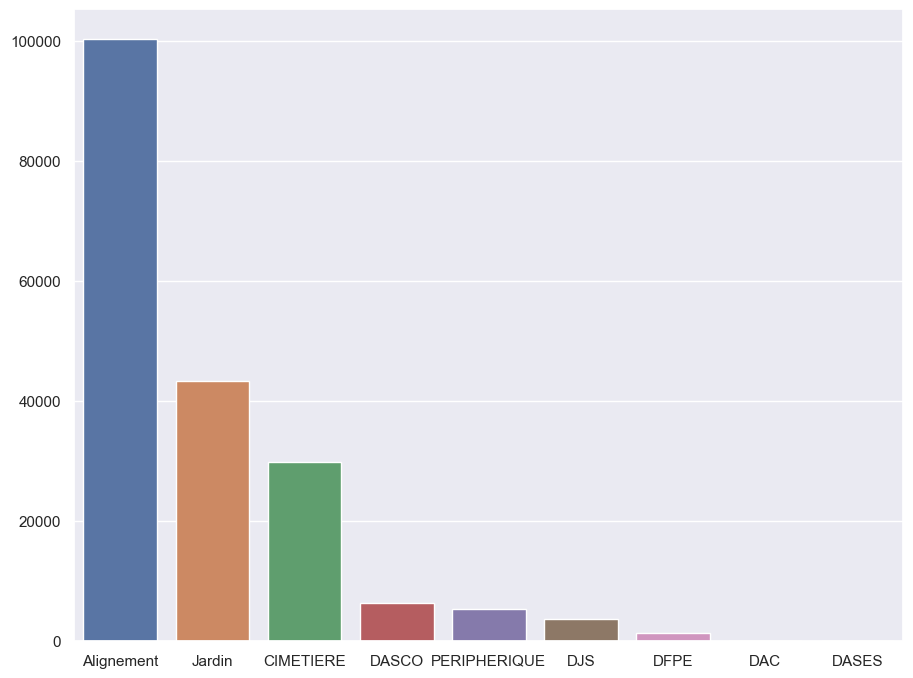

In [53]:
sns.set(rc={'figure.figsize': (10.7, 8.2)})
keys = list(quantite_espece_domanialite.keys())
vals = [float(quantite_espece_domanialite[k]) for k in keys]
sns.barplot(x=keys, y=vals)

On constate que la majorité des arbres se trouvent dans l'Alignement, puis dans les jardins et les cimetiere.

Maintenant, regardons ensemble la quantité d'arbres par espèce et par domanialité.

In [54]:
# Nous créons une nouvelle dataframe composée des colonnes 'domanialite' et 'libelle_francais'

df_domanialite = df[['domanialite','libelle_francais']]
domanialite_list = df['domanialite'].unique().tolist()

domanialite = {}

# Ici nous plaçons les dans le dictionnaire 'quantite_arbre_total_espece' la quantité d'arbres par espèce
# en fonction de la domanialité utilisée dans la boucle, nous avons donc l'arbre en clé, et sa quantité en valeurs.
# Ensuite, nous plaçons dans le dictionnaire 'domanialite', la domanialite en clé, et
# le dictionnaire quantite_arbre_total_espece en valeur.

for domanialitee in domanialite_list:
    quantite_arbre_total_espece = {}
    for e in list_espece :
        esp_quantite = df_domanialite.loc[(df_domanialite['libelle_francais'] == e) & (df['domanialite'] == domanialitee)].count()
        quantite_arbre_total_espece[e] = esp_quantite['domanialite']
        
    domanialite[domanialitee] = quantite_arbre_total_espece

Nous créons un dictionnaire avec pour clé la domanialité et pour valeur les 5 arbres les plus présents dans cette domanialité.

In [55]:
dict_max_domanialite = {}

# Dans cette boucle, nous explorons chaque clé du dictionnaire 'domanialite', puis nous classons dans l'ordre décroissant
# les valeurs des clés, nous gardons les 5 premières clé qui correspondent aux arbres les plus présents de la domanialité
# et nous plaçons tout ça dans le dictionnaire 'dict_max_domanialite' qui aura donc pour clé la domanialité et comme valeur
# la liste des 5 arbres les plus présents dans sa domanialité.

# Pour rendre cela plus visible nous rendons le dictionnaire en dataframe.

for dicte in domanialite:
    max_key = sorted(domanialite[dicte], key=domanialite[dicte].get, reverse=True)[:5]
    dict_max_domanialite[dicte] = max_key

df_max_domanialite = pd.DataFrame.from_dict(dict_max_domanialite)

df_max_domanialite

,Jardin,Alignement,DJS,DFPE,CIMETIERE,DASCO,DAC,PERIPHERIQUE,DASES,NaN
0,Tilleul,Platane,Tilleul,Erable,Erable,Marronnier,Tilleul,Erable,Platane,Marronnier
1,Erable,Marronnier,Erable,Cerisier à fleurs,Marronnier,Platane,Platane,Platane,Marronnier,If
2,Pin,Tilleul,Pin,Bouleau,Tilleul,Erable,Aubepine,Peuplier,If,Erable
3,Marronnier,Sophora,Charme,Tilleul,Platane,Tilleul,Cerisier à fleurs,Robinier,Erable,Arbre à miel
4,Chêne,Erable,Robinier,Platane,Frêne,Pommier à fruits,Erable,Frêne,Arbre à miel,Sophora


Nous allons maintenant visualiser la quantité d'arbres par stade de développement.

In [56]:
dict_quantite_arbre_dev_total = {}

# Nous plaçons dans le dictionnaire dict_quantite_arbre_dev_total le stade de développement en clé et la quantité d'arbres
# ayant ce stade de développement en valeur.

# La condition permet de ne pas prendre en compte un stade de développement 'NaN' présent dans la dataframe, qui n'a pour
# valeur que 0.
# Et enfin nous classons les clés par ordre décroissant de leur valeur.

for stade_dev in list_stade_developpement:
    if type(stade_dev) == str:
        quantite_arbre_dev_total = df.loc[(df['stade_developpement'] == stade_dev)].count()
        dict_quantite_arbre_dev_total[stade_dev] = quantite_arbre_dev_total.loc['id']

dict_quantite_arbre_dev_total = {k: v for k, v in sorted(dict_quantite_arbre_dev_total.items(),
                                                         key=lambda item: item[1], reverse=True)}

dict_quantite_arbre_dev_total

{'A': 157111, 'J': 20107, 'JA': 12707, 'M': 12}

<Axes: >

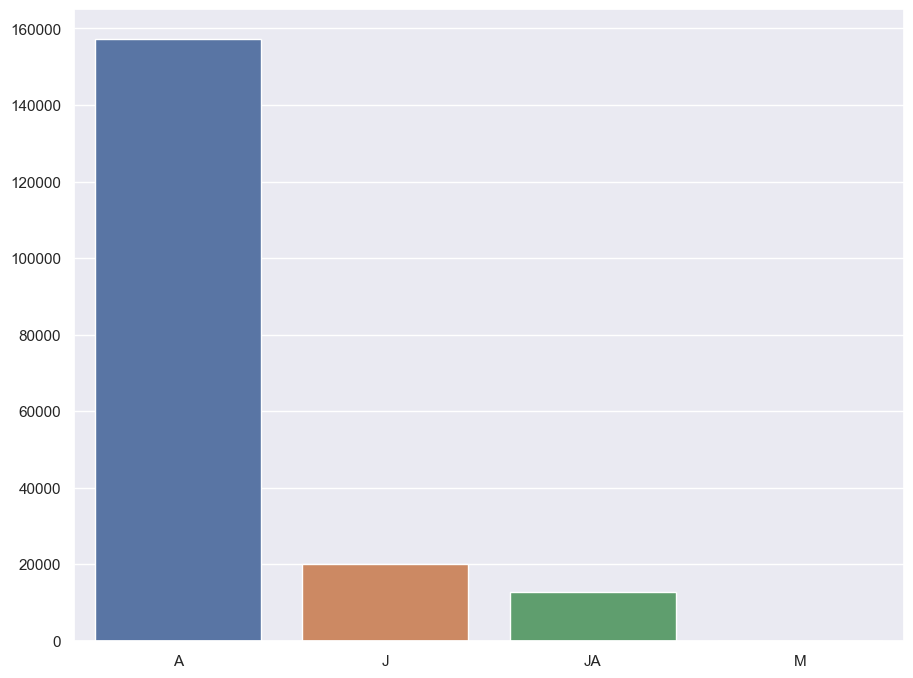

In [57]:
sns.set(rc={'figure.figsize':(10.7,8.2)})
keys = list(dict_quantite_arbre_dev_total.keys())
vals = [float(dict_quantite_arbre_dev_total[k]) for k in keys]
sns.barplot(x=keys, y=vals)

On peut donc voir que le stade de développement d'arbres le plus présent est le stade de développement A (Adulte).

## Visualisation geographique

Visualisons maintenant les arbres géographiquement.

Nous allons visualiser les arbres présents dans les cimetières pour identifier sur la carte les clusters, nous pourront le faire pour chaque domanialité, mais nous nous limiterons aux cimetières.

Ensuite, nous visualiserons les arbres remarquables sur la carte.

In [58]:
df_map_cimetiere = df[['domanialite',
                       'stade_developpement',
                       'libelle_francais',
                       'geo_point_2d_a',
                       'geo_point_2d_b']][df['domanialite'] == 'CIMETIERE'].sample(500)

# Pourcentage des arbres les plus présents dans les cimetières.
df_map_cimetiere['libelle_francais'].value_counts(normalize=True).round(2).head(5) * 100

libelle_francais
Erable        22.0
Marronnier    14.0
Platane        9.0
Tilleul        9.0
Frêne          6.0
Name: proportion, dtype: float64

In [59]:
paris = folium.Map(location=[48.856578, 2.351828], zoom_start=11)

for index, row in df_map_cimetiere.iterrows():

    if row["stade_developpement"] == 'J':
        color = 'blue'
    elif row["stade_developpement"] == 'AJ':
        color = 'red'
    elif row["stade_developpement"] == 'A':
        color = 'green'
    elif row["stade_developpement"] == 'M':
        color = 'orange'
    else:
        color = None

    if color is not None:
        folium.Marker(
            location=[row["geo_point_2d_a"], row["geo_point_2d_b"]],
            icon=folium.Icon(color=color),
        ).add_to(paris)

paris

Nous pouvons voir clairement où se trouve les différents cimetières de Paris avec les positions des différents arbres.

Passons maintenant aux arbres remarquables.

In [60]:
df_map_remarquable = df[['domanialite',
                         'remarquable',
                         'libelle_francais',
                         'geo_point_2d_a',
                         'geo_point_2d_b']][df['remarquable'] == True]

# Pourcentage des arbres les plus remarquables.
df_map_remarquable['libelle_francais'].value_counts(normalize=True).round(2).head(5) * 100

libelle_francais
Chêne                   10.0
Plaqueminier             8.0
Hêtre                    8.0
Noisetier de Byzance     6.0
Lilas de Perse           4.0
Name: proportion, dtype: float64

In [61]:
paris = folium.Map(location=[48.856578, 2.351828], zoom_start=11)

for index, row in df_map_remarquable.iterrows():
    folium.Marker(
        location=[row["geo_point_2d_a"], row["geo_point_2d_b"]],
        icon=folium.Icon(color='green'),
    ).add_to(paris)

paris

L'espèce d'arbre ayant le plus d'arbres ramarquable est le Chêne.

# Conclusion

L'analyse du jeu de données est maintenant terminée, avec les statistiques que nous avions faîte, nous pouvons maintenant gérer le parc et la végétalisation de Paris plus efficacement, savoir quels équipements prendre pour quel endroit lors des entretiens des arbres par exemple, ou diriger les touristes vers les emplacements d'arbres remarquables.